# Overview processing steps

<img src="figures/dtw_pipeline.png" height=400 />

This markdown file contains the following processing steps.

1. Merge body and hands time series and apply linear interpolation, normalization, and smoothing (C--E)

2. Calculate finger tip positions relative to the wrist (F)

3. Trim the time series data for the gesture duration based on ELAN annotations (G)

4. Create a distance matrix with dynamic time warping distances between two gestures (H)

# 0. Import packages & define directories

⚠️ Before running the script, make sure to place the MediaPipe output time series data in the `data/mediapipe/output_timeseries/` and `data/mediapipe/output_timeseries_flipped/` folders. The time series data can be downloaded from the OSF repository.

In [ ]:
# loading in some basic packages
import numpy as np                           # basic data operations
import pandas as pd                          # data wrangling
import os                                    # for foldering       
import glob                                  # for file handling  
from tqdm import tqdm                        # for progress bars
from scipy.ndimage import gaussian_filter1d  # for smoothing
from scipy.spatial import distance
import matplotlib.pyplot as plt              # for plotting
from scipy.stats import pearsonr, spearmanr  # for correlation
import statsmodels.formula.api as smf        # for linear regression
from warnings import simplefilter            # for ignoring warnings
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# loading custom-made functions
from functions import (preprocess_ts, fill_missing_values, normalize_size, 
                       normalize_position, adjust_aspect_ratio, flip_y_axis, 
                       export_merge_annot, export_merge_annot_size, make_export_size_df)
from dtw_functions import get_keypoints, get_relative_keypoints, make_export_dtw_df

# initializing some folders and files
timeseries_folder = "../data/mediapipe/output_timeseries/"
flipped_timeseries_folder = "../data/mediapipe/output_timeseries_flipped/"
# list of all the folders in the time series folder
ts_folders = os.listdir(timeseries_folder)
ts_folders_flipped = os.listdir(flipped_timeseries_folder)

anno_path = "../data/elan_annotation/"
processed_folder = "../data/processed/"
merged_folder = processed_folder + "01_merged_ts/"
interpolated_folder = processed_folder + "02_interpolated_ts/"
norm_smooth_folder = processed_folder + "03_normalized_and_smoothed_ts/"
ts_annot_folder = processed_folder + "04_ts_aligned_gesture/"
ts_annot_folder_flipped = ts_annot_folder + "flipped/"

# setting up autoreload for interactive development
%load_ext autoreload
%autoreload 2

# 1 & 2. Preprocess MediaPipe time series

We will perform the following preprocessing on the timeseries data:

1. merge body and hands time series data into one pandas dataframe
2. calculate relative finger positions
3. interpolate the missing values
4. apply smoothing
5. normalize for size and position
6. adjust for aspect ratio
7. flip y axis
8. calculate relative finger positions

**Why do we interpolate missing values?**

Sometimes, mediapipe fails to estimate the location of a joint and returns no value. This leads to timeseries data with missing values or NaNs and can cause errors when computing distance using DTW.

To tackle this, we will fill missing values based on the most adjacent values for the particular keypoint. For example, imagine that the "X_LEFT_THUMB_TIP" consisted of 5 missing values like this: 0.5, 0.4, NaN, NaN, NaN, NaN, NaN, -0.2. In this case, we will fill the NaNs in a way that the value immediately before the first NaN and the one immediately after the last NaN are equally distanced, like this: 0.5, 0.4, 0.3, 0.2, 0.1, 0, -0.1, -0.2. This can offer a reasonable estimate for where the hand was for the missing points.

**Why do we smooth the data?**

We will apply smoothing because most likely, there will be noise-related jitter in the time series data.

**Why do we use relative finger positions for DTW instead of raw coordinates?**
We use relative finger positions because if we use raw coordinates of each finger tip, difference in location would be penalized 6 times when running DTW.

Imagine a scenario where two speakers produced identical gestures---perfect alignment in handshape, orientation, and movement---but in difference positions. Ideally, we would get a very low DTW distance score, as only the location differs between the gestures. However, computing DTW distance on raw coordinates may return a high distance, because difference in location is not only reflected in the wrists coordinates but also in the coordinates of each finger tip. This means that difference in location is reflected in **6 keypoints**, giving more weights to location. See example below:

<img src="figures/relative_finger_position.svg" height=500 />


One solution to this is to calculate relative finger positions and compute DTW on the wrist and each finger tip. This way, only the wrists contain information about the location of the hands, and finger tips will not be affected by the difference in hand locations. We can comupte the relative location by `finger_tip_loc - wrist_loc`.

**Why do we normalize for size and position?**

We normalize size and position to ensure a consistent representation of poses across different frames and individuals. In other words, normalization reduces noise in the data caused by variation in the location of participant. 

Consider a case where in one video (video A) a participant is standing on the left of the video at 1m from the camera and in another video (video B) the same participant is standing on the right side at 2m from the camera. In this case, values for x-axis is (almost) always lower for video A because of the participant appears on the left in video A while they appear on the right in video B. In addition, the same movements look bigger in video B because the participant is closer to the camera. In this case, applying size and position normalization can "move" the participant to the center of the video so that the difference in standing position does not affect timeseries data.

**Why do we adjust for aspect ratio and flip y-axis?**

We adjust the values for x- and y-axis to align the unit size for x and y. For example, for a video with 16:9 aspect ratio (e.g., 1920:1080), if moving a hand 5 cm horizontally corresponds to 0.1 in x, moving a hand 5 cm vertically corresponds to about 0.18 in y. This difference arises because although the width of video is larger than the height, the range of MediaPipe unit is 0 to 1 for both x and y.

In addition, we will flip the y-axis because mediapipe output unit for y-axis is conterintuitve: 0 means top and 1 means bottom of the frame.

**Why do we use relative finger positions instead of original positions?**

We use relative finger positions to minimize the chance of inflating the distance due to different hand positions. For example, imagine that we have front-view recordings for two speakers, and they produced the identical movements but in different positions. In this case, the pattern in ts will be identical, but the values (coordinates) of the wrist AND finger tips will be different. In other words, each keypoint encodes the information about its trajectories as well as its location. Therefore, DTW "penalizes" the difference in position for each keypoint, in our case, 6 times per hand. By using the relative positions for each joints, only the wrist will be penalized.

In [ ]:
# load in data
ts_file_list = [timeseries_folder + file_name + "/" + file_name for file_name in ts_folders \
                if file_name not in [".DS_Store", ".gitkeep"] and ".zip" not in file_name]
ts_file_flipped_list = [flipped_timeseries_folder + file_name + "/" + file_name for file_name in ts_folders_flipped \
                        if file_name not in [".DS_Store", ".gitkeep"] and ".zip" not in file_name]
count_files = len(ts_file_list)
skip_count = 0
existing_files = []
body_cols_to_keep = ["time", 
                     "X_LEFT_SHOULDER", "Y_LEFT_SHOULDER", "Z_LEFT_SHOULDER",
                     "X_RIGHT_SHOULDER", "Y_RIGHT_SHOULDER", "Z_RIGHT_SHOULDER",
                     "X_LEFT_HIP", "Y_LEFT_HIP", "Z_LEFT_HIP",
                     "X_RIGHT_HIP", "Y_RIGHT_HIP", "Z_RIGHT_HIP"]

### preprocess the time series
for file in tqdm(ts_file_list):
    filename = file.split("/")[-1]
    if os.path.exists(norm_smooth_folder + filename + "_ns.csv"):
        skip_count += 1
        existing_files.append(file)
        continue

    ### preprocess the time series
    preprocess_ts(file, body_cols_to_keep, merged_folder, interpolated_folder, norm_smooth_folder)

### preprocess the flipped time series
for file in tqdm(ts_file_flipped_list):
    filename = file.split("/")[-1]
    if os.path.exists(norm_smooth_folder + "flipped/" + filename + "_ns.csv"):
        skip_count += 1
        existing_files.append(file)
        continue

    ### preprocess the time series
    preprocess_ts(file, body_cols_to_keep, merged_folder, interpolated_folder, norm_smooth_folder, flipped = True)

if skip_count > 0:
    print(f"Skipped {skip_count} files that already exist in the normalized and smoothed folder.")
    print(existing_files)

### Example illustrating the effect of interpolation, smoothing, and normalization.

In [ ]:
ex_original = pd.read_csv(merged_folder + "030_b_merged.csv")
# ex_original = ex_original[(ex_original["time"] >= 229300) & (ex_original["time"] <= 230000)] <- example used in the paper
ex_original = ex_original[(ex_original["time"] >= 305000) & (ex_original["time"] <= 310000)]

ex_interpolated = fill_missing_values(ex_original.copy())

xyz_cols = [col for col in ex_interpolated.columns if col.startswith("X_") or col.startswith("Y_") or col.startswith("Z_")]
ex_smoothed = ex_interpolated[xyz_cols].apply(lambda x: gaussian_filter1d(x, sigma = 2))
ex_smoothed.insert(0, 'time', ex_interpolated["time"])

ex_normalized = normalize_size(ex_smoothed.copy())
ex_normalized = normalize_position(ex_normalized)
ex_normalized = adjust_aspect_ratio(ex_normalized)
ex_normalized = flip_y_axis(ex_normalized)

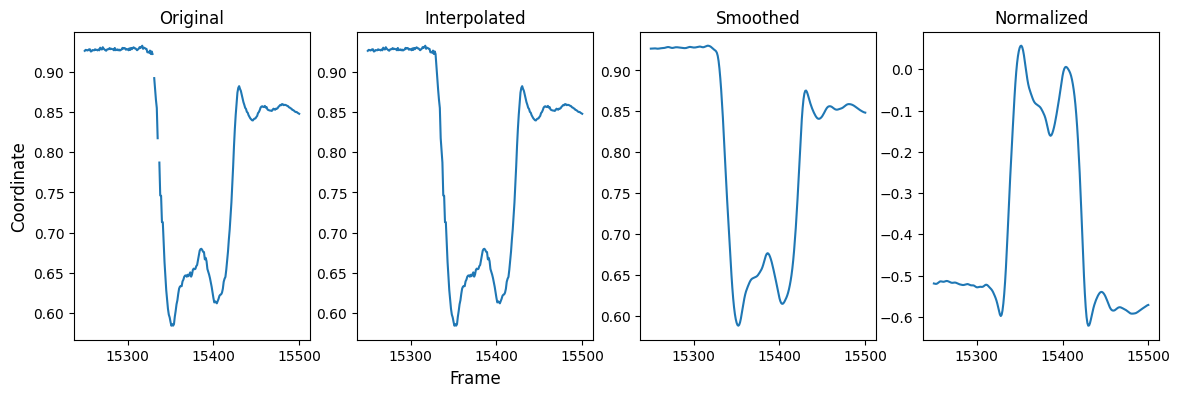

In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 4))

ax1.plot(ex_original[["Y_LEFT_WRIST"]])
ax1.set_title("Original")
ax1.set_ylabel("Coordinate", fontsize=12)

ax2.plot(ex_interpolated[["Y_LEFT_WRIST"]])
ax2.set_title("Interpolated")
ax2.set_xlabel("Frame", fontsize=12)

ax3.plot(ex_smoothed[["Y_LEFT_WRIST"]])
ax3.set_title("Smoothed")

ax4.plot(ex_normalized[["Y_LEFT_WRIST"]])
ax4.set_title("Normalized")

fig.savefig("figures/normalization_smoothing.png", dpi = 300)

As can be seen in the second plot, the missing values are interpolated linearly. Of course this is not a perfectly accurate estimates for the missing values, but we will use it as a good-enough approximation.

Based on the last figure, it looks like the smoothing was applied successfully. Note that the plot looks fliped because we flipped the y-axis for enhanced intellibility.

# 3. Trim ts data for gesture duration

### Preprocess ELAN files
Here, we will preprocess all ELAN annotation files

In [ ]:
annots = os.listdir(anno_path)

# load in the annotations for gesture similarity coding
for anno_filename in annots:
    if anno_filename.endswith(".csv") and "processed" not in anno_filename:
        output_file = anno_path + anno_filename.split(".csv")[0] + "_processed.csv"
        if os.path.exists(output_file):
            print("File already exists: " + output_file)
            continue
        anno = pd.read_csv(anno_path + anno_filename)
        # create a comparison_id column that starts from 1 and increments by 1. This will be used when computing the distance matrix using DTW
        anno["comparison_id"] = anno.index + 1

        ### make a new column and fill it with the adjusted duration for gestures that are less than 330 milliseconds
        anno["begin_time_1_adj"] = np.where(anno["duration_1"] < 330, 
                                            anno["begin_time_1"] + (anno["duration_1"] - 330)/2, anno["begin_time_1"])
        anno["end_time_1_adj"] = np.where(anno["duration_1"] < 330,
                                            anno["end_time_1"] - (anno["duration_1"] - 330)/2, anno["end_time_1"])
        anno["duration_1_adj"] = anno["end_time_1_adj"] - anno["begin_time_1_adj"]
        anno["begin_time_2_adj"] = np.where(anno["duration_2"] < 330, 
                                            anno["begin_time_2"] + (anno["duration_2"] - 330)/2, anno["begin_time_2"])
        anno["end_time_2_adj"] = np.where(anno["duration_2"] < 330,
                                            anno["end_time_2"] - (anno["duration_2"] - 330)/2, anno["end_time_2"])
        anno["duration_2_adj"] = anno["end_time_2_adj"] - anno["begin_time_2_adj"]

        ### make a new column for handedness to decide for which hand(s) the distance should be calculated
        anno["A_hands"] = np.where((anno["A_LH_gesture_referent_1"].notna() | anno["A_LH_gesture_referent_2"].notna()) & 
                                    (anno["A_RH_gesture_referent_1"].notna() | anno["A_RH_gesture_referent_2"].notna()), "both", 
                                        np.where(anno["A_LH_gesture_referent_1"].notna() | anno["A_LH_gesture_referent_2"].notna(), "left",
                                            np.where(anno["A_RH_gesture_referent_1"].notna() | anno["A_RH_gesture_referent_2"].notna(), "right", None)))
        anno["B_hands"] = np.where((anno["B_LH_gesture_referent_1"].notna() | anno["B_LH_gesture_referent_2"].notna()) &
                                    (anno["B_RH_gesture_referent_1"].notna() | anno["B_RH_gesture_referent_2"].notna()), "both",
                                        np.where(anno["B_LH_gesture_referent_1"].notna() | anno["B_LH_gesture_referent_2"].notna(), "left",
                                            np.where(anno["B_RH_gesture_referent_1"].notna() | anno["B_RH_gesture_referent_2"].notna(), "right", None)))
        # A & B both -> both; A left & B right -> left_right; A right & B left -> right_left; A left & B left -> left; A right & B right -> right
        anno["hands_dtw"] = np.where((anno["A_hands"].str.endswith("left")) & (anno["B_hands"].str.endswith("left")), "left",
                                        np.where((anno["A_hands"].str.endswith("right")) & (anno["B_hands"].str.endswith("right")), "right", 
                                            np.where((anno["A_hands"].str.endswith("left")) & (anno["B_hands"].str.endswith("right")), "left_right",
                                                np.where((anno["A_hands"].str.endswith("right")) & (anno["B_hands"].str.endswith("left")), "right_left", "both"))))

        anno.to_csv(output_file, index=False)

        anno[['comparison_id', 'begin_time_1', 'end_time_1', 'begin_time_2', 'end_time_2',
            'duration_1', 'duration_2',
            'begin_time_1_adj', 'end_time_1_adj', 'begin_time_2_adj', 'end_time_2_adj',
            'duration_1_adj', 'duration_2_adj', 'hands_dtw']].head()

### Export time series data for each aligned gesture

In [ ]:
MT_files = glob.glob(norm_smooth_folder + "*.csv")
MT_files_flipped = glob.glob(norm_smooth_folder + "flipped/" + "*.csv")
anno = pd.read_csv(anno_path + "gestural_alignment_processed.csv")

export_merge_annot(MT_files, anno, ts_annot_folder, adj_dur=True)
export_merge_annot(MT_files_flipped, anno, ts_annot_folder_flipped, adj_dur=True)

# 4. Compute DTW distance
Next, we will compute distance matrix for each gesture comparison pair (distance between gesture 1 and gesture 2) to measure (dis)similarity of two gestures.

We will perform asymmetric, loose beginning & end constraints DTW to account for potential inaccuracy in segmentation. For more details about the benefits of loose beginning and end, please see [this paper](https://ieeexplore.ieee.org/document/7837974). We only use the DTW distance for gesturing hands when calculating the average distance.

Note that in cases where one speaker produced left-handed gesture and the other speaker right-handed gesture, we will compute the following two distance scores and take the smallest distance:

- DTW distance between speaker A's original gesture and B's original gesture
- DTW distance between speaker A's original gesture and B's flipped gesture

<img src="figures/dtw_example_mirrored.svg" height=250 />

In [ ]:
relative_keypoints = get_relative_keypoints()
anno = pd.read_csv(anno_path + "gestural_alignment_processed.csv")
make_export_dtw_df(processed_folder, ts_annot_folder, relative_keypoints, anno, use_mirrored_ts=True)